# Visualization of multidimensional data 

In [147]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn import datasets

## Dataset 

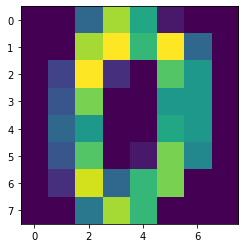

In [156]:
digits  =  datasets.load_digits()

X = digits.data / digits.data.max()
labels = digits.target

plt.imshow(X[0].reshape(8, 8))

## t-SNE

In [168]:
class TSNE:
    def __init__(self, 
                 dims=2, 
                 perplexity=30.0, 
                 alpha = 0.5, 
                 learning_rate=1000):
        
        self.dims = dims
        self.perplexity = perplexity
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.eps = 1e-4
        self.gains_inc = 0.2
        self.gains_dec = 0.8
                
    
    def h_beta(self, D, beta = 1.0):
        P = np.exp(-D.copy() * beta)
        sum_P = sum(P)
        H = np.log(sum_P) + beta * np.sum(D * P) / sum_P
        P = P / sum_P
        return H, P
    
    
    def get_p_values(self, X):
        n, d = X.shape
        
        sum_X = np.sum(np.square(X), 1)
        D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
        P = np.zeros((n, n))
        beta = np.ones((n, 1))
        logU = np.log(self.perplexity)

        for i in tqdm(range(n)):
            beta_min, beta_max = -np.inf, np.inf
            Di = D[i, np.concatenate((np.r_[0 : i], np.r_[i + 1 : n]))]
            H, cur_P = self.h_beta(Di, beta[i])

            diff = H - logU
            while np.abs(diff) > self.eps:
                if diff > 0:
                    beta_min = beta[i].copy()
                    if beta_max == np.inf or beta_max == -np.inf:
                        beta[i] = beta[i] * 2.
                    else:
                        beta[i] = (beta[i] + beta_max) / 2.
                else:
                    beta_max = beta[i].copy()
                    if beta_min == np.inf or beta_min == -np.inf:
                        beta[i] = beta[i] / 2.
                    else:
                        beta[i] = (beta[i] + beta_min) / 2.

                H, cur_P = self.h_beta(Di, beta[i])
                diff = H - logU

            P[i, np.concatenate((np.r_[0 : i], np.r_[i + 1 : n]))] = cur_P

        P = P + P.T
        P = P / np.sum(P)
            
        return P
    
    
    def calc_gains(self, gains, grads, dY):
        inc = (gains + self.gains_inc) * ((grads > 0) != (dY > 0))
        dec = (gains * self.gains_dec) * ((grads > 0) == (dY > 0))
        return inc + dec
        
        
    def init_var(self, n):
        Y = np.random.randn(n, self.dims)
        dY = np.zeros((n, self.dims))
        grads = np.zeros((n, self.dims))
        gains = np.ones((n, self.dims))
        return Y, dY, grads, gains
    
        
    def fit_transform(self, X, n_iter = 100):
        n, d = X.shape
        Y, dY, grads, gains = self.init_var(n)
        P = self.get_p_values(X)
        
        for j in tqdm(range(n_iter)):
            sum_Y = np.sum(np.square(Y), 1)
            num = -2. * np.dot(Y, Y.T)
            num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
            Q = num / np.sum(num)
            
            PQ_diff = P - Q
            for i in range(n):
                grads[i, :] = np.sum(np.tile(PQ_diff[:, i] * num[:, i], 
                                             reps=(self.dims, 1)).T * 
                                     (Y[i, :] - Y), 
                                     axis=0)

            gains = self.calc_gains(gains, grads, dY)
            dY = self.alpha * dY - self.learning_rate * (gains * grads)
            Y += dY
            
        return Y

## Example 

In [169]:
tsne = TSNE()
Y = tsne.fit_transform(X, n_iter=50)

100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


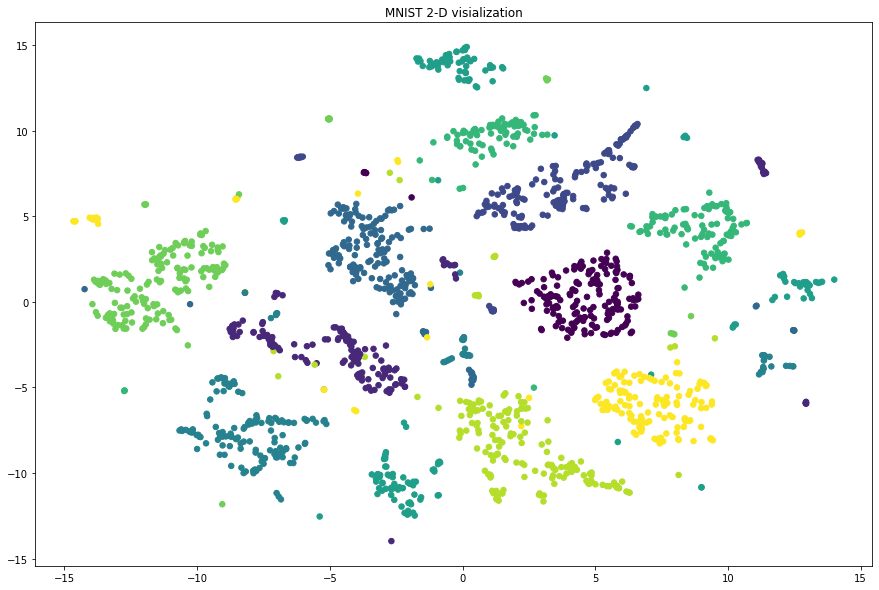

<Figure size 432x288 with 0 Axes>

In [174]:
plt.figure(figsize=(15, 10))
plt.scatter(Y[:, 0], Y[:, 1], s=30, c=digits.target)
plt.title("MNIST 2-D visialization")
plt.savefig("minst.jpg")
plt.show()